In [115]:
# Import basic packages
import pandas as pd
import numpy as np
from pathlib import Path

# Import skleanr packages
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import _name_estimators, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

# Import LightGBM
import lightgbm as lgb
import xgboost as xgb

import matplotlib.pyplot as plt

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/camilleepitalon/miniconda3/envs/bikes-ramp/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Users/camilleepitalon/miniconda3/envs/bikes-ramp/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file)"]


In [112]:
def merge_external_data(X): 
    
    '''
    Enriches the input dataframe with weather data (merges on 'date')
    
    Parameters:
        X (pd.DataFrame): the dataframe to enrich
    
    Returns:
        X (pd.DataFrame): the enriched dataframe
    '''

    # Duplicate X to work on it
    X = X.copy()
    X.loc[:, "date"] = pd.to_datetime(X["date"])
    
    # Create X_weather, the dataframe with the wanted weather data
    file_path = Path(__file__).parent / "external_data.csv"
    df_weather = pd.read_csv(file_path, parse_dates=["date"])
    X_weather = df_weather[['date', 't', 'rr3', 'u']]
    
    # Reset index
    X["orig_index"] = np.arange(X.shape[0])
    
    # Merge X_weather to X, on the closest value of column X.date
    X_merged = pd.merge_asof(X.sort_values("date"), X_weather.sort_values("date"), on='date')
    
    # Clean the merged dataframe
    X_merged['t'] = X_merged['t'].fillna(0)
    X_merged['rr3'] = X_merged['rr3'].fillna(0)
    X_merged['u'] = X_merged['u'].fillna(0)
    X_merged = X_merged.sort_values("orig_index")
    X_merged.drop(columns=["orig_index", 'counter_id', 'site_name', 'counter_installation_date', 'counter_technical_id', 'latitude', 'longitude'], inplace=True)
    
    # Render the new dataframe X
    X = X_merged
    return X

def merge_covid_data(X):

    '''
    Enriches the input dataframe with quarantine and curfew data (merges on 'date')
    
    Parameters:
        X (pd.DataFrame): the dataframe to enrich
    
    Returns:
        X (pd.DataFrame): the initial dataframe
    '''

    # Create 2 columns: date_only and hour_only
    date_and_time = pd.to_datetime(X['date'])
    X['date_only'] = date_and_time
    new_date = [dt.date() for dt in X['date_only']]
    X['date_only'] = new_date
    X['hour_only'] = date_and_time
    new_hour = [dt.hour for dt in X['hour_only']]
    X['hour_only'] = new_hour

    # Create a mask to spot the days under quarantine in Paris
    is_quarantine = (
        (X['date_only'] >= pd.to_datetime('2020/10/30'))
        & (X['date_only'] <= pd.to_datetime('2020/12/15')) | 
        (X['date_only'] >= pd.to_datetime('2021/04/03'))
        & (X['date_only'] <= pd.to_datetime('2021/05/03'))
    )

    # Create a mask to spot the days under curfew in Paris
    is_curfew = (
        (X['date_only'] >= pd.to_datetime('2021/01/16'))
        & (X['date_only'] < pd.to_datetime('2021/03/20'))
        & ((X['hour_only'] >= 18) | (X['hour_only'] <= 6)) |
        (X['date_only'] >= pd.to_datetime('2021/03/20'))
        & (X['date_only'] < pd.to_datetime('2021/05/19'))
        & ((X['hour_only'] >= 19) | (X['hour_only'] <= 6)) |
        (X['date_only'] >= pd.to_datetime('2021/05/19'))
        & (X['date_only'] < pd.to_datetime('2021/06/9'))
        & ((X['hour_only'] >= 21) | (X['hour_only'] <= 6)) |
        (X['date_only'] >= pd.to_datetime('2021/06/9'))
        & (X['date_only'] < pd.to_datetime('2021/06/20'))
        & ((X['hour_only'] >= 21) | (X['hour_only'] <= 6))
    )

    # Create the associated columns
    X['quarantine'] = np.where(is_quarantine, 1, 0)
    X['curfew'] = np.where(is_curfew, 1, 0)

    # Clean the new dataframe and return it
    X.drop(columns=['hour_only', 'date_only'], inplace=True)
    return X

def _encode_dates(X):
    
    '''
    Splits the 'date' columns of the input DataFrame into several columns (year, month, day, weekday, hour)
    
    Parameters:
        X (pd.DataFrame): the dataframe to modify
    
    Returns:
        X (pd.DataFrame): the modified dataframe
    '''
    
    # Duplicate X to work on it
    X = X.copy()
    
    # Create new columns with date parts from X.date
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour
    
    # Clean the new dataframe and return it
    X.drop(columns=["date"], inplace=True)
    return X

def _encode_dates_poly(X):
    
    '''
    Splits the 'date' columns of the input DataFrame into several columns (year, month, day, weekday, hour)
    
    Parameters:
        X (pd.DataFrame): the dataframe to modify
    
    Returns:
        X (pd.DataFrame): the modified dataframe
    '''
    
    # Duplicate X to work on it
    X = X.copy()
    
    # Create new columns with date parts from X.date
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour
    
    # Clean new X dataframe
    X = X.drop(columns=["date"])

    # Adding polynomial features from date variables 
    numeric_encoder = StandardScaler()
    X_encoded = numeric_encoder.fit_transform(X[['month', 'day', 'weekday', 'hour']])
    X_encoded = pd.DataFrame(X_encoded, columns=['month', 'day', 'weekday', 'hour'])

    poly_encoder = PolynomialFeatures(degree=3)
    dates_poly = poly_encoder.fit_transform(X_encoded)
    dates_col = poly_encoder.get_feature_names(X[['month', 'day', 'weekday', 'hour']].columns)
    X_encoded.drop(columns=['month', 'day', 'weekday', 'hour'])
    dates_poly = pd.DataFrame(dates_poly, columns=dates_col)
    dates_poly.drop(columns=['1', 'month', 'day', 'weekday', 'hour'], inplace=True)
    X.reset_index(drop=True, inplace=True)
    X = X_encoded.join(dates_poly).join(X.drop(columns=['year', 'month', 'day', 'weekday','hour']))

    # Adding cosinus and sinus features from date variables to enhance the date periodicity
    X['cos_hour'] = np.cos(X['hour']*(2.*np.pi/24))
    X['sin_hour'] = np.sin(X['hour']*(2.*np.pi/24))
    X['cos_day'] = np.cos(X['day']*(2.*np.pi/30))
    X['sin_day'] = np.sin(X['day']*(2.*np.pi/30))
    X['cos_month'] = np.cos(X['month']*(2.*np.pi/12))
    X['sin_month'] = np.sin(X['month']*(2.*np.pi/12))
    X['cos_weekday'] = np.cos(X['weekday']*(2.*np.pi/7))
    X['sin_weekday'] = np.sin(X['weekday']*(2.*np.pi/7))

    return X

def get_estimator():
    
    '''
    Creates a pipe which:
        (1) performs all the transformations done by the functions merge_external_data() and _encode_dates(),
        (2) encodes the categorical and numerical data, 
        (3) performs a LightGBM regression with tuned parameters.

    Parameters:
        None

    Returns:
        pipe (sklearn Pipeline objet): the given pipeline
    '''

    # Call the merge_external_data function
    merge_external = FunctionTransformer(merge_external_data, validate=False)
    #merge_covid = FunctionTransformer(merge_covid_data, validate=False)

    # Call the _encode_dates function to split the date column to several columns
    date_encoder = FunctionTransformer(_encode_dates)
    #date_encoder_poly = FunctionTransformer(_encode_dates_poly)
    
    # Encode the final columns
    categorical_encoder = OneHotEncoder(handle_unknown="ignore")
    categorical_cols = ["counter_name", 'site_id']
    numeric_encoder = StandardScaler()
    numeric_cols = ['t', 'u','rr3', 'year', 'month', 'day', 'weekday', 'hour']
    ordinal_encoder = OrdinalEncoder()
    #numeric_cols = ['t', 'u','rr3', 'month', 'day', 'weekday', 'hour', 'month^2', 'month day', 'month weekday', 'month hour', 'day^2', 'day weekday', 'day hour', 'weekday^2', 'weekday hour', 'hour^2', 'month^3', 'month^2 day', 'month^2 weekday', 'month^2 hour', 'month day^2', 'month day weekday', 'month day hour', 'month weekday^2', 'month weekday hour', 'month hour^2', 'day^3', 'day^2 weekday', 'day^2 hour', 'day weekday^2', 'day weekday hour', 'day hour^2', 'weekday^3', 'weekday^2 hour', 'weekday hour^2', 'hour^3']
    #date_one_encoder = OneHotEncoder(handle_unknown="ignore")
    #date_cols = ['year', 'month', 'day', 'weekday', 'hour']
    
    # Create a ColumnTransformer object to perform all encodings
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", categorical_encoder, categorical_cols),
            ("numeric", numeric_encoder, numeric_cols) 
            #("date", date_one_encoder, date_cols),
        ]
        #, remainder='passthrough'
    )
    
    # Set the best parameters values for our LightBGM model
    params1 = {  
        'lambda_l1' : 4, 
        'lambda_l2' : 18, 
        'num_leaves' : 99, 
        'max_depth' : 11,
        'num_iterations' : 240,
        'min_child_samples' : 7,
        'max_bin' : 200, 
        #'n_estimators' : 100, <-- doesn't change anything
        #'subsample_for_bin' :  200,
        #'subsample' : 1,
        #'subsample_freq' : 1,
        #'reg_alpha' : 0.306, 
        #'reg_lambda' : 0.306, 
        #'min_split_gain' : 0.5,
        #'min_child_weight' : 1,
        #'learning_rate' : 0.025
        }
    
    params2 = {
        'max_depth': 24,
        'num_leaves': 2**10,
        'min_data_in_leaf':40,
        'learning_rate':0.1,
        'n_estimators': 130,
        'max_bin': 340,
        'lambda_l1': 0.01 ,
        'lambda_l2': 0,
        'min_gain_to_split':0,
        'boosting_type' : 'gbdt',
        'metric' : 'rmse'
        }

    params3 = {
        'colsample_bytree': 0.7, 
        'learning_rate': 0.01,
        'max_depth': 11,
        'min_child_samples': 198,
        'min_child_weight': 0.1,
        'n_estimators': 2000,
        'num_leaves': 99,
        'reg_alpha': 1, 
        'reg_lambda': 0.1,
        'subsample': 0.5
    }
    
    # Create the regressor object 
    regressor = xgboost.xgb()

    # Create pipeline
    pipe = make_pipeline(
        merge_external,
        #merge_covid,
        #date_encoder_poly,
        date_encoder, 
        preprocessor, 
        regressor
    )
    
    return pipe

In [113]:
__file__ = Path("submissions") / "starting_kit" / "estimator.py"

train = pd.read_parquet("data/train.parquet")
test = pd.read_parquet("data/test.parquet")

In [114]:
pipe = get_estimator()

NameError: name 'xgboost' is not defined

In [26]:
X_train = train.drop(columns=['log_bike_count'])
y_train = train['log_bike_count']

In [27]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function merge_external_data at 0x7fd6d88ec670>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7fd6e8c9eee0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_id']),
                                                 ('numeric', StandardScaler(),
                                                  ['t', 'u', 'rr3', 'year',
                                                   'month', 'day', 'weekday',
                                                   'hour'])])),
                ('lgbmregressor',
                 LGBMRegressor(colsample_bytree=0.7, learning_rate=0.01,
                               max_depth=11, min_child_samples=19

In [28]:
y_pred = pipe.predict(X_train)

In [50]:
y_pred

array([0.08296167, 0.67880295, 0.44933996, ..., 4.09244628, 3.98037362,
       4.75694933])

In [49]:
df_y_pred = pd.DataFrame(y_pred, columns=['y_pred'])
df_y_pred

,y_pred
0,0.082962
1,0.678803
2,0.449340
3,1.983598
4,1.540670
...,...
455158,4.039217
455159,0.921612
455160,4.092446
455161,3.980374


In [51]:
__file__ = Path("submissions") / "starting_kit" / "estimator.py"

train = pd.read_parquet("data/train.parquet")
test = pd.read_parquet("data/test.parquet")

train.reset_index(inplace=True, drop=True)
df_y_pred = pd.DataFrame(y_pred, columns=['y_pred'])
X = train.join(df_y_pred)
X

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count,y_pred
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000,0.082962
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147,0.678803
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000,0.449340
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438,1.983598
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585,1.540670
...,...,...,...,...,...,...,...,...,...,...,...,...
455158,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,51.0,2021-08-08 18:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,3.951244,4.039217
455159,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,1.0,2021-08-09 02:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,0.693147,0.921612
455160,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,61.0,2021-08-09 08:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,4.127134,4.092446
455161,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,44.0,2021-08-09 10:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,3.806662,3.980374


In [107]:
mask = (
    (X["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X["date"] > pd.to_datetime("2021/03/01"))
    & (X["date"] < pd.to_datetime("2021/03/10"))
)

df_viz = X.loc[mask].copy()
df_viz["bike_count"] = np.exp(df_viz['log_bike_count']) - 1
df_viz["bike_count (predicted)"] = np.exp(df_viz['y_pred']) - 1

In [92]:
mask = (
    (X["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X["date"] > pd.to_datetime("2020/03/01"))
    & (X["date"] < pd.to_datetime("2020/03/10"))
)

df_viz = X.loc[mask].copy()
df_viz

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count,y_pred
3850,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2021-03-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000,-0.142563
3853,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,8.0,2021-03-01 07:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.197225,1.749257
3856,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,5.0,2021-03-01 08:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.791759,1.678610
3859,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,7.0,2021-03-01 11:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.079442,1.467059
3862,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2021-03-01 12:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438,1.434503
...,...,...,...,...,...,...,...,...,...,...,...,...
452399,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,75.0,2021-03-08 19:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,4.330733,4.277500
452402,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,8.0,2021-03-08 21:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,2.197225,2.154828
452405,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,7.0,2021-03-09 04:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,2.079442,1.903115
452408,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,97.0,2021-03-09 13:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,4.584967,4.682229


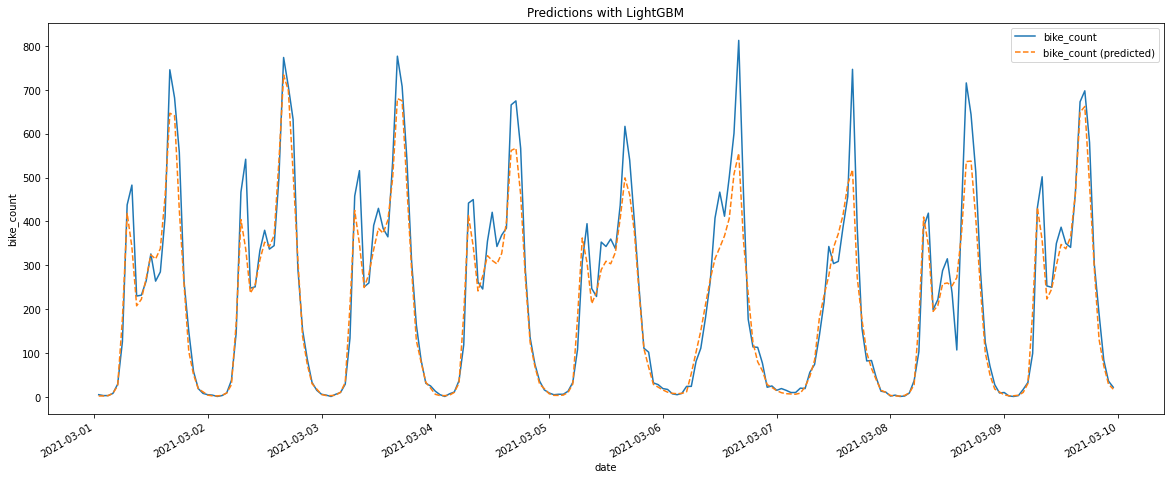

In [108]:
fig, ax = plt.subplots(figsize=(20, 8))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with LightGBM")
ax.set_ylabel("bike_count")
plt.savefig("pred.jpg")

In [ ]:
plt.savefig("pred.jpg")